In [5]:
import pandas as pd   
import numpy as np
from textblob import TextBlob  
import sys            
import tweepy         
import os
import nltk
import pycountry
import re
import string

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

# Settings for Matplotlib graphs and charts
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [47]:
## load the data
data = pd.read_excel('data.xlsx', engine='openpyxl')
data.head()

,Date,Time,user_id,location,text
0,2021-02-11,19:03:21,b'BurtonKelso',b'Greater Kansas City Area',b'... that time I met @antoni from @QueerEye !...
1,2021-02-11,19:02:38,b'AnaraPublishing',"b'Leicester, England'",b'With platforms like #Netflix and #AmazonPrim...
2,2021-02-11,19:01:05,b'WiltsColl',"b'Wiltshire, UK'","b'This time last week, we were still buzzing f..."
3,2021-02-11,19:00:41,b'poem1985',b'United Kingdom',b'Had a gorgeous tea &amp; now gonna chill wit...
4,2021-02-11,19:00:32,b'screenkingsPH',b'Philippines',b'#NewsOfTheWorld now streaming on Netflix! (E...


## Data Preprocessing 

Before we start our sentiment analysis it is a good idea to clean up each tweets from an unnecessary data first.

We are going to create a cleanUpTweet function that will:

- remove mentions
- remove hashtags
- remove retweets
- remove urls

In [17]:
## drop the columns we don't really need
df = data.drop(columns=['Date', 'Time', 'user_id', 'location'])
df.head

<bound method NDFrame.head of                                                    text
0     b'... that time I met @antoni from @QueerEye !...
1     b'With platforms like #Netflix and #AmazonPrim...
2     b'This time last week, we were still buzzing f...
3     b'Had a gorgeous tea &amp; now gonna chill wit...
4     b'#NewsOfTheWorld now streaming on Netflix! (E...
...                                                 ...
3994  b'Watch  In HD now!!\nfollow the link and enjo...
3995  b'\xe2\x80\x98Behind Her Eyes\xe2\x80\x99 Netf...
3996  b'Everyone is ways talking about the friends s...
3997  b'Who\xe2\x80\x99s watched the superb #CallMyA...
3998  b'Netflix \xc2\xa311.99 to \xc2\xa313.99 \xf0\...

[3999 rows x 1 columns]>

In [48]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
data = pd.DataFrame(data)
data["text"] = data

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
data["text"] = data.text.map(remove_rt).map(rt)
data["text"] = data.text.str.lower()
data.head(10)

NameError: name 'text' is not defined

In [49]:
 
def clean_tweet(text):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

## Calculate the Sentiment score using TextBlob

In [20]:
df.drop_duplicates(inplace = True)

Extracting text values
text_all = tweet_list[0].values text_neutral = neutral_list[0].values text_positive = positive_list[0].values text_negative = negative_list[0].values

In [21]:
import nltk
nltk.download('vader_lexicon')

#Calculating Negative, Positive, Neutral and Compound values

df[['polarity', 'subjectivity']] = df['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in df['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        df.loc[index, 'sentiment'] = "positive"
    else:
        df.loc[index, 'sentiment'] = "neutral"
    df.loc[index, 'neg'] = neg
    df.loc[index, 'neu'] = neu
    df.loc[index, 'pos'] = pos
    df.loc[index, 'compound'] = comp

df.head(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nanas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,b that time i met from he didn xe2 x...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
1,b with platforms like netflix and amazonprim...,0.250000,0.312500,positive,0.105,0.786,0.109,0.0256
2,b this time last week we were still buzzing f...,0.200000,0.483333,positive,0.000,0.854,0.146,0.5574
3,b had a gorgeous tea amp now gonna chill wit...,0.700000,0.900000,positive,0.000,0.733,0.267,0.6124
4,b newsoftheworld now streaming on netflix e...,0.250000,1.000000,negative,0.218,0.782,0.000,-0.6486
5,b it s dropping on netflix tomorrow xe2 x99 ...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
6,b new trailer pacific rim the black on netfl...,-0.015152,0.443939,neutral,0.000,1.000,0.000,0.0000
7,b iron fist finn jones reveals plot details f...,0.000000,0.000000,positive,0.000,0.797,0.203,0.4215
8,b malcolmandmarie falls victim to its over d...,-0.225000,0.600000,negative,0.205,0.698,0.098,-0.3182
9,b is it just me or you guys also obsessed with...,-0.500000,1.000000,negative,0.044,0.956,0.000,-0.1779


## Word Cloud Dictionary

In [22]:
#Creating new data frames for all sentiments (positive, negative and neutral)

df_negative = df[df["sentiment"]=="negative"]
df_positive = df[df["sentiment"]=="positive"]
df_neutral = df[df["sentiment"]=="neutral"]

In [23]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [24]:
#Count_values for sentiment
pc = count_values_in_column(df,"sentiment")
pc

,Total,Percentage
positive,1741,46.24
neutral,1331,35.35
negative,693,18.41


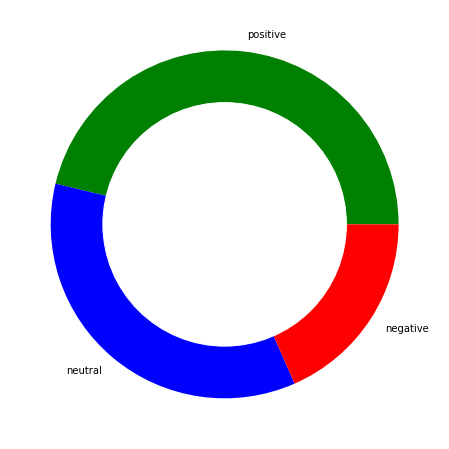

In [25]:
# create data for Pie Chart
pichart = count_values_in_column(df,"sentiment")
names= pc.index
size = pc ["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

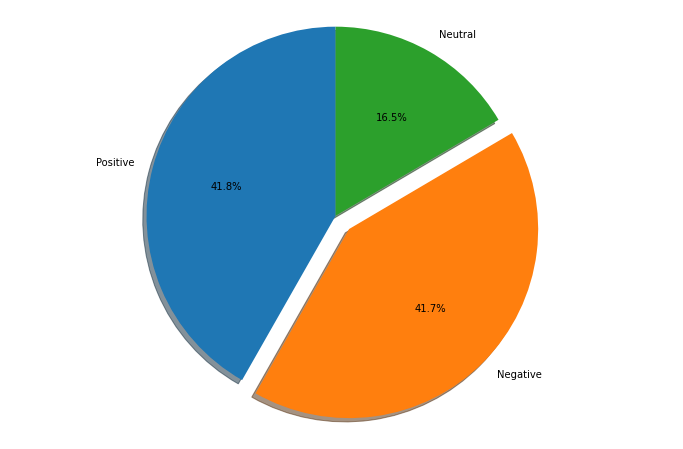

In [26]:
labels = 'Positive', 'Negative', 'Neutral'
sizes = [1572, 1570, 622]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [27]:
#Function to Create Wordcloud

def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=3000,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


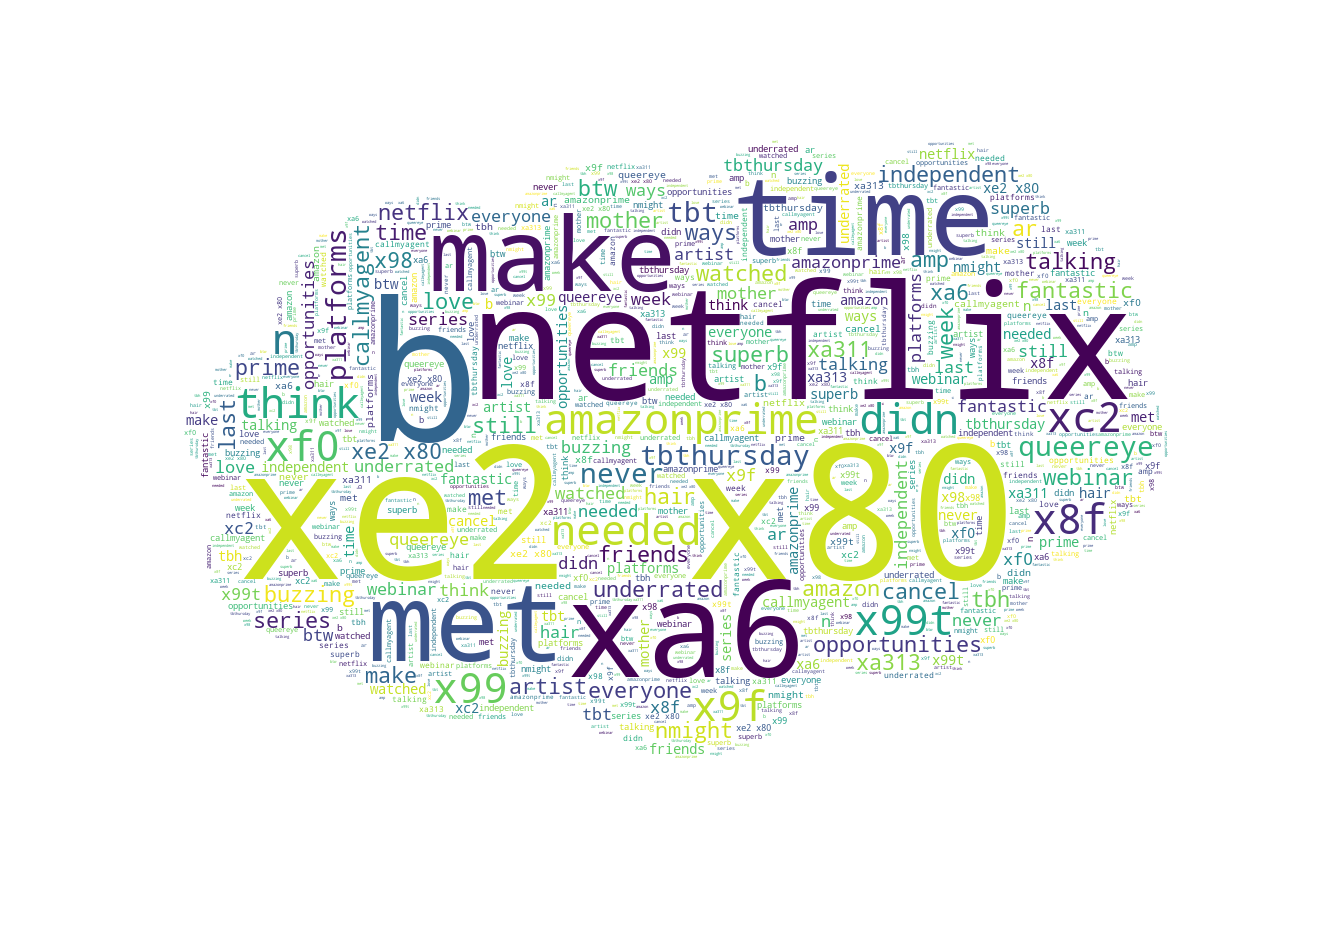

In [28]:
#Creating wordcloud for all tweets
create_wordcloud(df["text"].values)

Word Cloud Saved Successfully


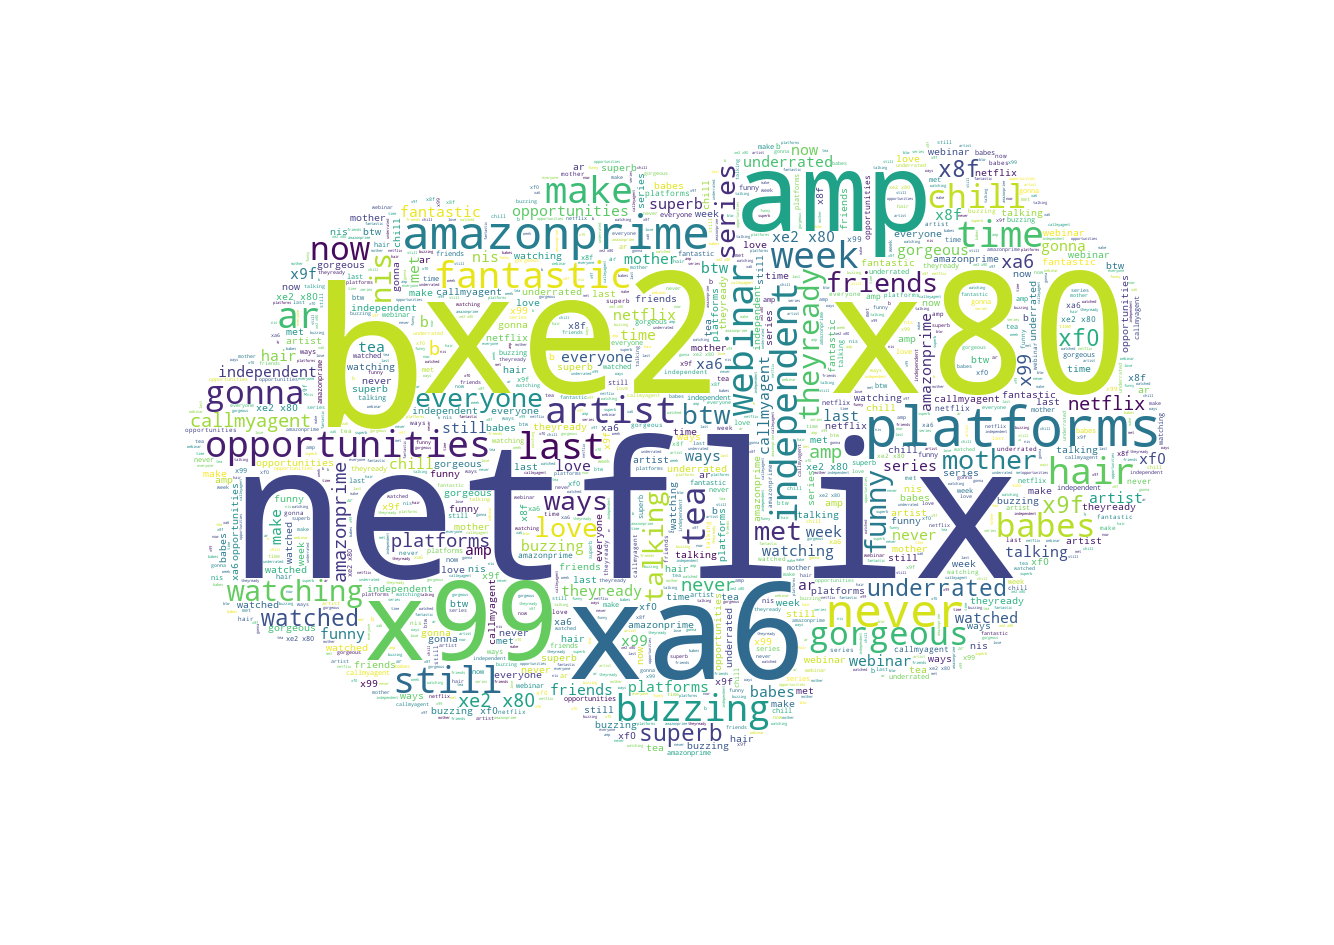

In [29]:
#Creating wordcloud for all positive tweets
create_wordcloud(df_positive["text"].values)

Word Cloud Saved Successfully


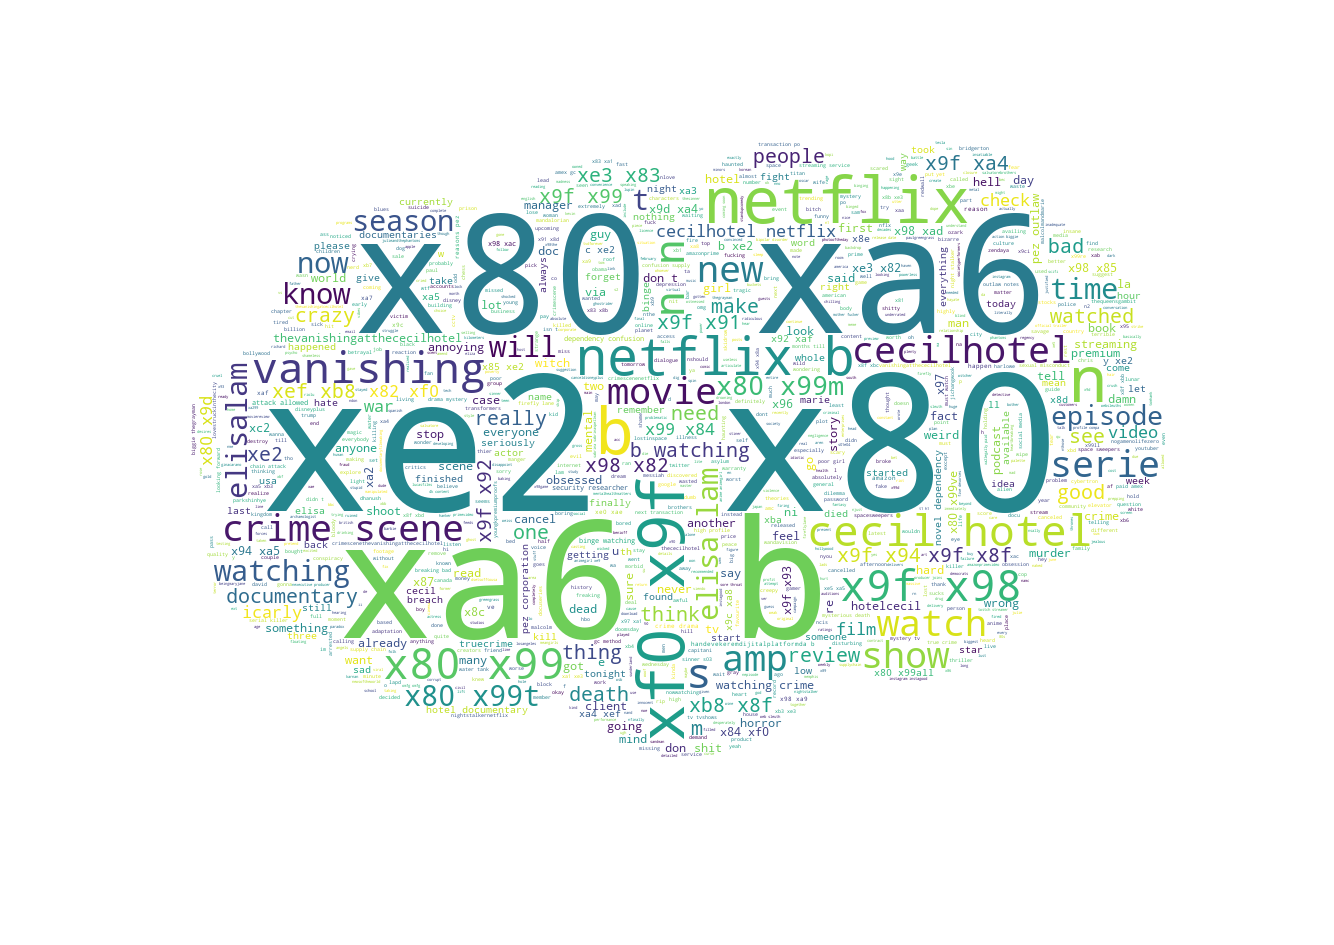

In [30]:
#Creating wordcloud for all negative tweets
create_wordcloud(df_negative["text"].values)

Word Cloud Saved Successfully


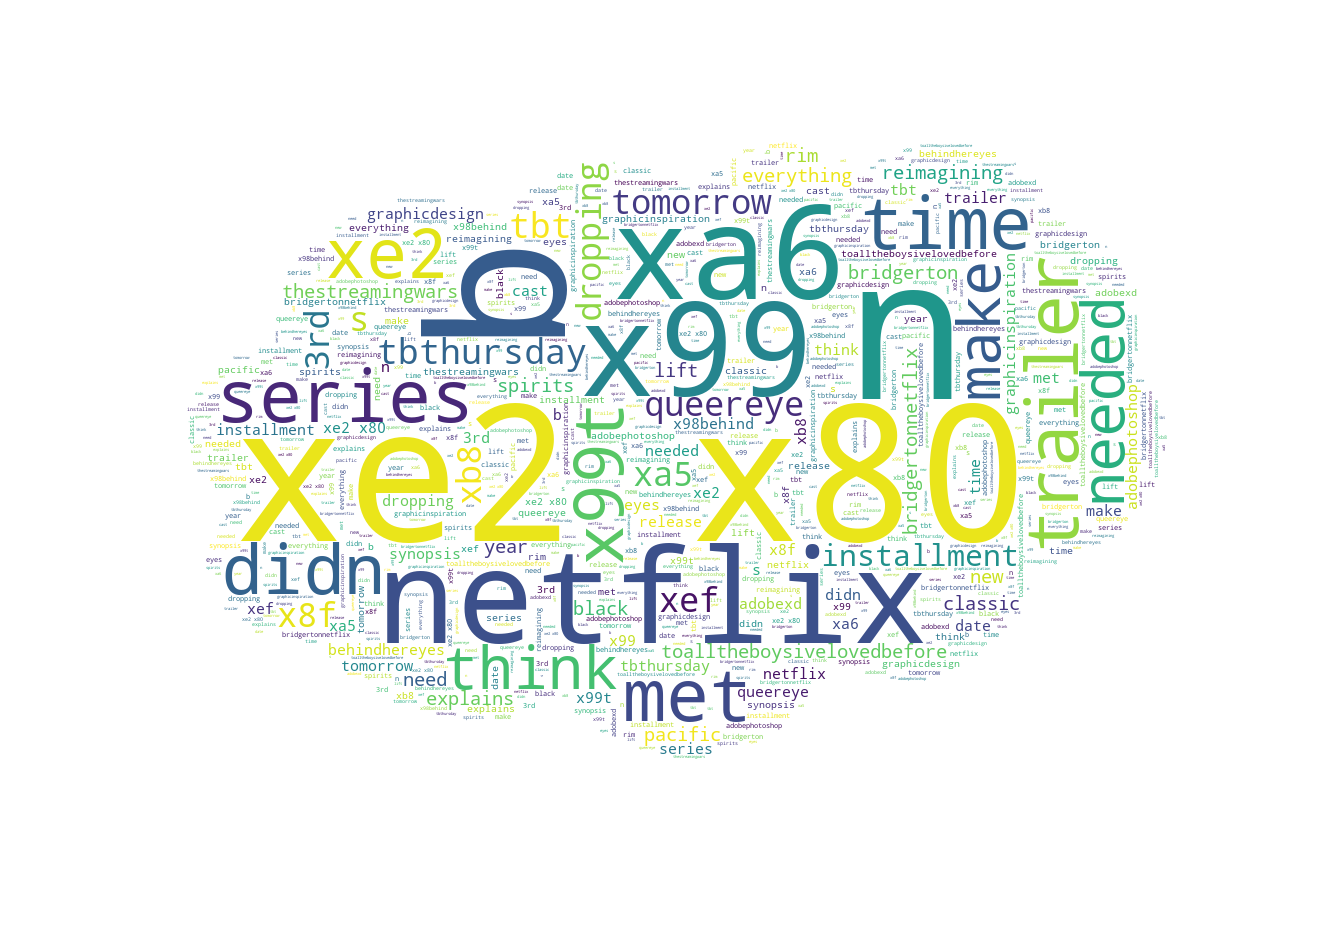

In [31]:
#Creating wordcloud for all neutral tweets
create_wordcloud(df_neutral["text"].values)

## Calculate the Ratio for the sentiment change

In [32]:
ratio = df.pos / (df.neg + df.pos)

In [33]:
ratio.head()

0         NaN
1    0.509346
2    1.000000
3    1.000000
4    0.000000
dtype: float64

In [37]:
df['ratio'] = ratio
df.head()

,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,ratio
0,b that time i met from he didn xe2 x...,0.00,0.000000,neutral,0.000,1.000,0.000,0.0000,NaN
1,b with platforms like netflix and amazonprim...,0.25,0.312500,positive,0.105,0.786,0.109,0.0256,0.509346
2,b this time last week we were still buzzing f...,0.20,0.483333,positive,0.000,0.854,0.146,0.5574,1.000000
3,b had a gorgeous tea amp now gonna chill wit...,0.70,0.900000,positive,0.000,0.733,0.267,0.6124,1.000000
4,b newsoftheworld now streaming on netflix e...,0.25,1.000000,negative,0.218,0.782,0.000,-0.6486,0.000000


Now let's concat our two data 

In [44]:
df_new = pd.merge(data, df)
df_new.head(5)

,Date,Time,user_id,location,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,ratio


In [35]:
df_new.describe()

,ratio
count,2440.000000
mean,0.702882
std,0.406809
min,0.000000
25%,0.426487
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
import matplotlib as plt 
df.sort_values(by='Time', inplace=True)
df.index = pd.to_datetime(df['Time'])
df['mean'] = df['compound'].expanding().mean()
df['rolling'] = df['compound'].rolling('6h').mean()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

In [ ]:
# plotting the points 
plt.plot(x = , y, color='green', linestyle='dashed', linewidth = 3, 
		marker='o', markerfacecolor='blue', markersize=12) 

# setting x and y axis range 
plt.ylim(1,8) 
plt.xlim(1,8) 

# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 

# giving a title to my graph 
plt.title('Some cool customizations!') 

# function to show the plot 
plt.show() 
